<a href="https://colab.research.google.com/github/sokrypton/ColabBio/blob/main/af3_hypothesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import jax.numpy as jnp # numpy on steroids
import string
import matplotlib.pyplot as plt

In [4]:
def con_auc(true, pred, mask=None, thresh=0.01):
  '''compute agreement between predicted and measured contact map'''
  if mask is not None:
    idx = mask.sum(-1) > 0
    true = true[idx,:][:,idx]
    pred = pred[idx,:][:,idx]
  eval_idx = np.triu_indices_from(true, 6)
  pred_, true_ = pred[eval_idx], true[eval_idx]
  L = (np.linspace(0.1,1.0,10)*len(true)).astype("int")
  sort_idx = np.argsort(pred_)[::-1]
  acc = [(true_[sort_idx[:l]] > thresh).mean() for l in L]
  return np.mean(acc)

def get_contacts(cov,A=21,do_apc=True):
  LA = cov.shape[0]
  L = LA//A
  cov = cov.reshape(L,A,L,A)[:,:20,:,:20]
  raw = np.sqrt(np.square(cov).sum((1,3)))
  np.fill_diagonal(raw,0)
  if do_apc:
    ap = raw.sum(0)
    apc = raw - (ap[:,None] * ap[None,:])/ap.sum()
    np.fill_diagonal(apc,0)
    return apc
  else:
    return raw

def parse_fasta(filename, a3m=False, stop=100000):
  '''function to parse fasta file'''
  if a3m:
    # for a3m files the lowercase letters are removed
    # as these do not align to the query sequence
    rm_lc = str.maketrans(dict.fromkeys(string.ascii_lowercase))

  header, sequence = [],[]
  lines = open(filename, "r")
  for line in lines:
    line = line.rstrip()
    if len(line) > 0:
      if line[0] == ">":
        if len(header) == stop:
          break
        else:
          header.append(line[1:])
          sequence.append([])
      else:
        if a3m: line = line.translate(rm_lc)
        else: line = line.upper()
        sequence[-1].append(line)
  lines.close()
  sequence = [''.join(seq) for seq in sequence]

  return header, sequence

def mk_msa(seqs):
  '''one hot encode msa'''
  alphabet = "ARNDCQEGHILKMFPSTWYV-"
  states = len(alphabet)
  a2n = {a:n for n,a in enumerate(alphabet)}
  msa_ori = np.array([[a2n.get(aa, states-1) for aa in seq] for seq in seqs])
  return np.eye(states)[msa_ori]

In [27]:
!wget --no-check-certificate -qnc https://gremlin2.bakerlab.org/db/ECOLI/fasta/P0A6A8.fas

In [120]:
msa = mk_msa(parse_fasta(filename="P0A6A8.fas")[1])
msa = msa[np.random.permutation(np.arange(msa.shape[0]))[:5000]]

In [121]:
msa.shape

(5000, 78, 21)

In [122]:
msa_flat = msa.reshape(msa.shape[0],-1)
cov = jnp.cov(msa_flat.T)
inv_cov = -jnp.linalg.inv(cov + 4.5/np.sqrt(msa_flat.shape[0]) * np.eye(cov.shape[0]))

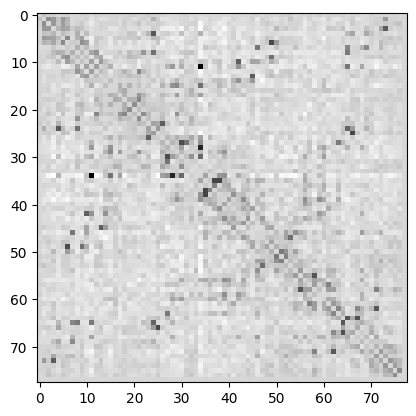

In [125]:
plt.imshow(get_contacts(inv_cov),cmap="gray_r")

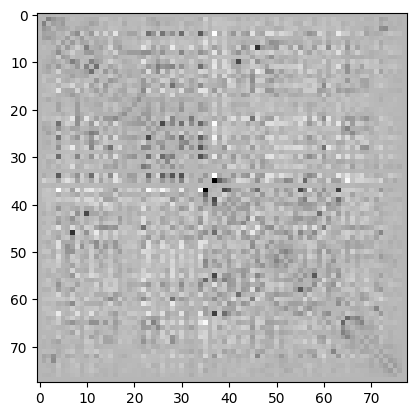

In [127]:
N,L,A = msa.shape
rep = msa.reshape(N,-1)
rep = rep - rep.mean(0)
plt.imshow(get_contacts(jnp.cov(rep.T)),cmap="gray_r")

In [128]:
N,L,A = msa.shape
rep = msa.reshape(N,-1)
rep = rep - rep.mean(0)

cons = [get_contacts(jnp.cov(rep.T))]
idx = jnp.triu_indices_from(inv_cov,1)
auc = [jnp.corrcoef(inv_cov[idx],jnp.cov(rep.T)[idx])[0,1]]
print(0,auc[-1])

for i in range(1,101):
  q = k = v = rep.T.copy()

  # outer-product-mean
  pair = (q @ k.T)/q.shape[0]

  # pair weighted averaging
  new_rep = []
  for h in range(8): # number of heads

    # random weights
    tmp = np.random.normal(size=(q.shape[0],1))

    tmp = pair @ tmp
    tmp /= jnp.sqrt(jnp.square(tmp).sum())
    att = tmp @ tmp.T
    rep_update = att @ v

    new_rep.append(rep_update.T)
  # "add" (aka. skip connection)
  rep -= 0.5 * np.mean(new_rep,0)

  x = jnp.corrcoef(inv_cov[idx],
                   jnp.cov(rep.T)[idx])[0,1]
  auc.append(x)
  cons.append(get_contacts(jnp.cov(rep.T)))
  print(i,auc[-1])

0 0.44179806
1 0.50038815
2 0.5692104
3 0.6130079
4 0.63775456
5 0.65612
6 0.67830515
7 0.6981486
8 0.7121489
9 0.725899
10 0.73926944
11 0.7532195
12 0.76335794
13 0.77135223
14 0.77865136
15 0.7868932
16 0.7941389
17 0.80046886
18 0.80638397
19 0.8118548
20 0.81534636
21 0.8213458
22 0.8245758
23 0.8284497
24 0.8324899
25 0.83685744
26 0.8405762
27 0.84370315
28 0.8457711
29 0.8482863
30 0.851509
31 0.8535611
32 0.85594887
33 0.8583583
34 0.86096156
35 0.86326146
36 0.8654304
37 0.868416
38 0.8708598
39 0.8732898
40 0.87516797
41 0.87705123
42 0.87858254
43 0.88058347
44 0.8820047
45 0.88390905
46 0.8861028
47 0.88755184
48 0.8897516
49 0.89130086
50 0.8927869
51 0.89437276
52 0.8955202
53 0.8971088
54 0.8979999
55 0.8990228
56 0.90010786
57 0.90150845
58 0.90264
59 0.90354806
60 0.90494674
61 0.90574384
62 0.9064893
63 0.9078941
64 0.9086735
65 0.9095946
66 0.9104693
67 0.9114472
68 0.91242373
69 0.9131359
70 0.9138709
71 0.9144704
72 0.91498333
73 0.9157918
74 0.9166077
75 0.917126

Text(0, 0.5, 'correlation')

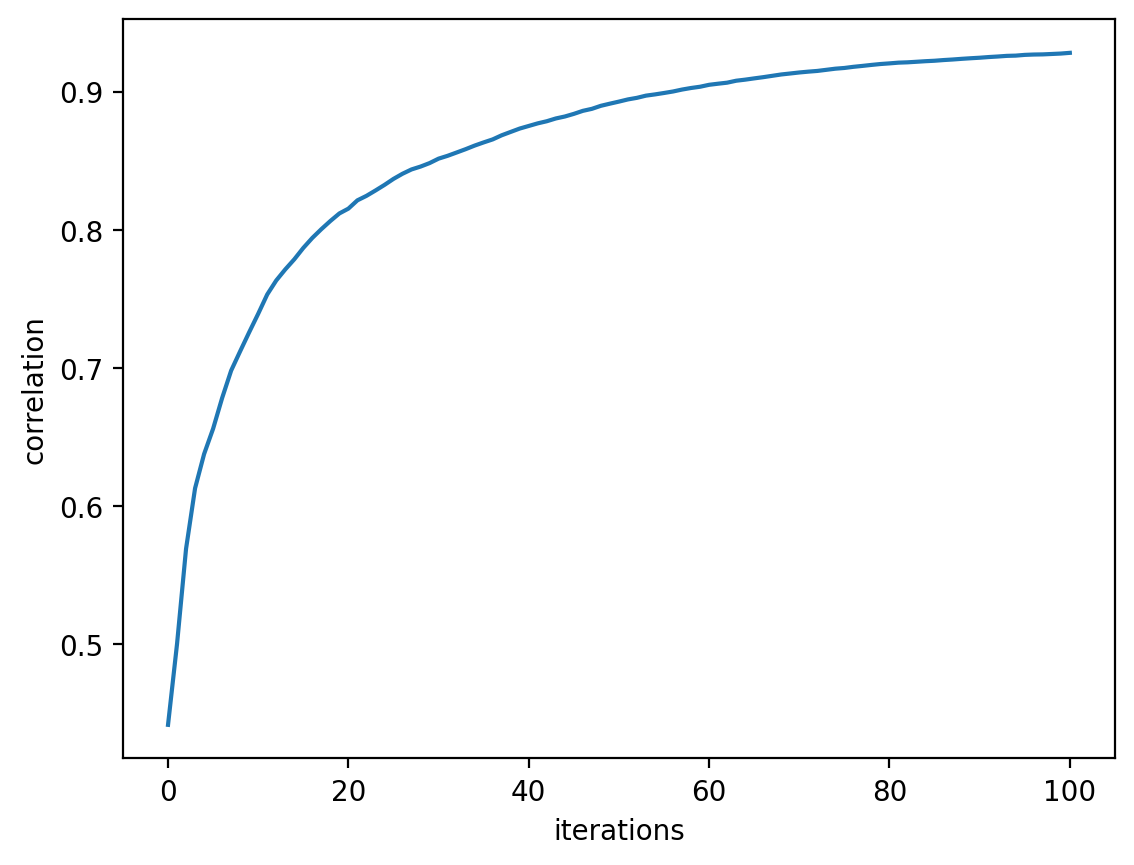

In [134]:
plt.figure(dpi=200)
plt.plot(auc)
plt.xlabel("iterations")
plt.ylabel("correlation")

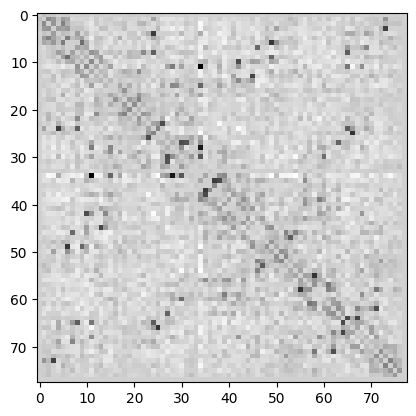

In [130]:
plt.imshow(-get_contacts(jnp.cov(rep.T)),cmap="gray")

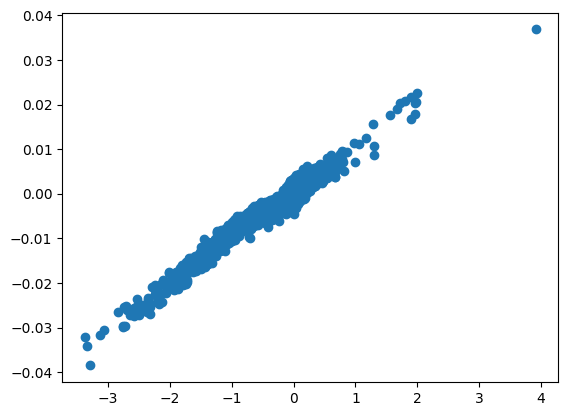

In [131]:
plt.scatter(inv_cov[idx],jnp.cov(rep.T)[idx])

In [132]:
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import matplotlib.patches as patches

def animate_heatmaps(X):
  fig, ax = plt.subplots()
  fig.set_figwidth(5);fig.set_figheight(5);fig.set_dpi(200)
  frames = []
  for k,x in enumerate(X):
    img = [ax.imshow(-x,
                     interpolation="none",
                     extent=(0, len(x), len(x), 0),
                     animated=True,
                     cmap="gray"),
           ax.text(0.5, 1.01, f"{k}", transform=ax.transAxes, ha='center')]
    frames.append(img)

  ani = ArtistAnimation(fig, frames, blit=True, interval=50)
  plt.close()
  return ani

In [133]:
HTML(animate_heatmaps(cons).to_html5_video())